## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import time
from os.path import exists

from models.neuralnetwork.spherical_cnn import SCNNModel
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical, scale_to_range
from sphericalharmonics.spherical_fourier_transform import get_spherical_fourier_transform
from sphericalharmonics.spherical_fourier_transform import get_design_matrix
from sphericalharmonics.spherical_fourier_transform import get_inverse_spherical_fourier_transform
from utils.logging import print_training_progress
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion
from lossfunctions.cross_correlation import CrossCorrelationLoss

# Spherical convolutional neural network for fODF estimation

## Hyperparameters

In [2]:
number_of_shells = 1
output_size = 45
learning_rate = 0.001
final_learning_rate = 0.0001
final_learning_rate2 = 0.00001
batch_size = 1000
num_batches = 100000
num_batches_lr_reduction = 40000
num_batches_lr_reduction2 = 60000
max_degree = 8
b_0_signal = 3000

## Load dataset

In [3]:
all_dwis = np.load('./data/planar/no_rotation/diffusion_weighted_signals.npy')
all_fODFs = np.load('./data/planar/no_rotation/fODF_sh_coefficients.npy')
all_qhat = np.load('./data/planar/no_rotation/gradient_orientations.npy')
all_bvals = np.load('./data/planar/no_rotation/b_values.npy')
all_dwis_sh_coefficients = None

## Normalize DWI signals

In [ ]:
all_dwis = all_dwis / b_0_signal

## Compute SH coefficients of DWI signals

In [ ]:
if(exists('./data/planar/no_rotation/diffusion_weighted_signals_sh_coefficients.npy')):
    all_dwis_sh_coefficients = np.load("./data/planar/no_rotation/diffusion_weighted_signals_sh_coefficients.npy")
else:
    

## Dataset plotting

In [5]:
plotting_index = 3

### Measurements

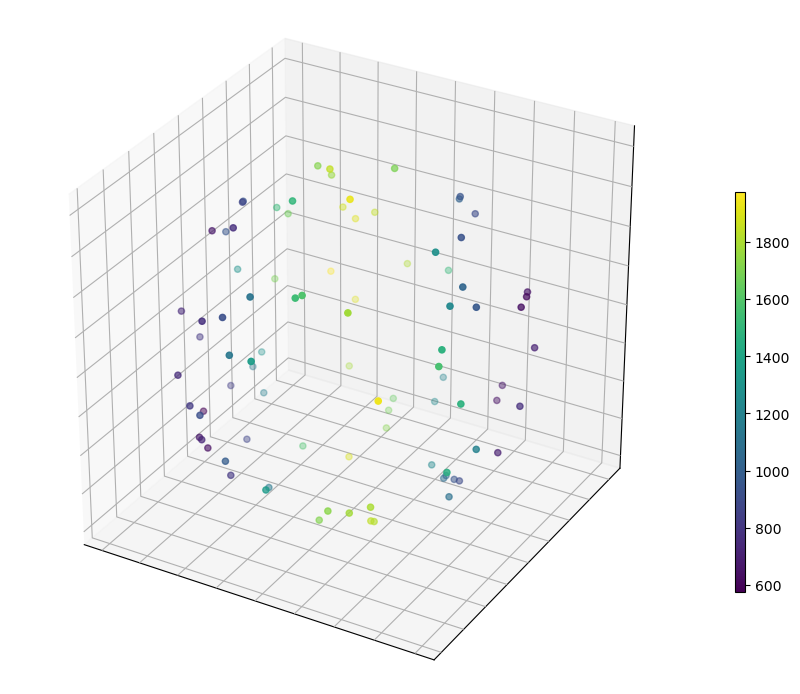

In [6]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection="3d")

# Remove ticks
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.xaxis.set_tick_params(color=(0, 0, 0, 0))
ax.yaxis.set_tick_params(color=(0, 0, 0, 0))
ax.zaxis.set_tick_params(color=(0, 0, 0, 0))

ax.scatter(all_qhat[plotting_index][0],all_qhat[plotting_index][1],all_qhat[plotting_index][2],c=all_dwis[plotting_index],vmin=np.min(all_dwis[plotting_index]),vmax=np.max(all_dwis[plotting_index]))
ax.set_aspect('equal')

# Add colorbar
cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(all_dwis[plotting_index]), vmax=np.max(all_dwis[plotting_index]))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

### Measurements (continuous)

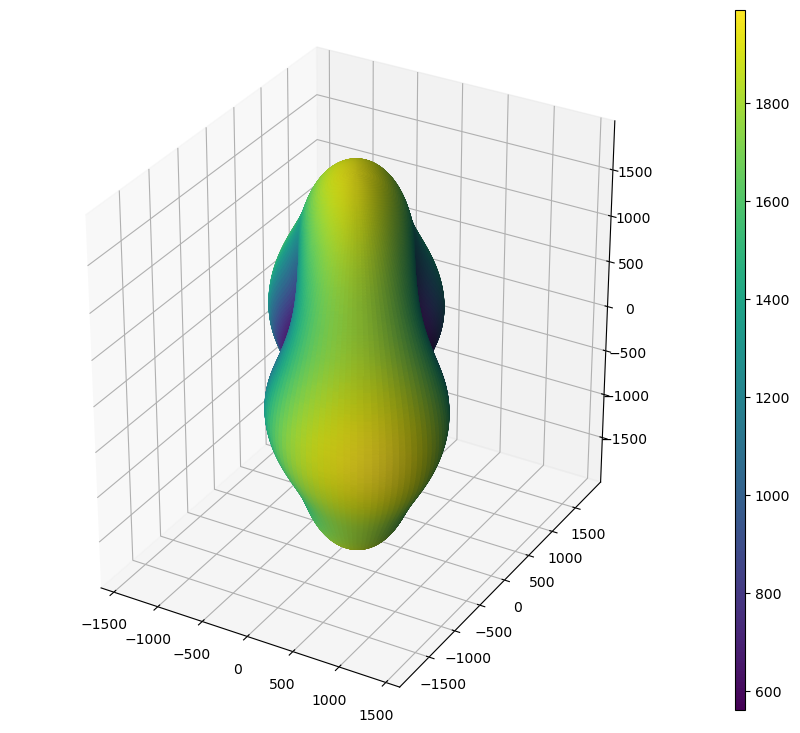

In [7]:
#%matplotlib qt

x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(all_dwis_sh_coefficients[plotting_index],max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cmap(normalization(fcolors)), shade=True)
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

### Measurement expansion coefficients

In [8]:
all_dwis_sh_coefficients[plotting_index]

array([ 4.52784647e+03, -1.24441945e+03, -5.25822455e-01,  4.41931232e+02,
        2.26996651e-01, -6.92277172e+02,  9.08330444e+01, -4.67504231e-01,
       -2.52632256e+02,  1.78098866e-01,  4.33217451e+02,  7.31956755e-02,
       -1.40377318e+02, -7.15401427e-02, -9.76455969e+01,  2.04262510e+01,
       -8.96596079e-02,  1.35788551e+01,  1.79534329e-02, -4.57909352e+01,
       -5.17647307e-01,  3.63375156e+00, -6.92757408e-01, -2.51113678e+01,
       -4.01980207e-01, -1.42585955e+01, -2.47179806e-01, -3.44779309e+01,
        8.12348707e+00,  3.35820232e-01,  1.89961069e+00,  5.26534458e-01,
        2.75025360e+00, -3.81541333e-02, -6.37889178e+00,  3.76157638e-01,
        1.38852719e+01,  8.98235276e-02, -3.23418780e+00,  8.44745848e-02,
       -2.12349451e+00, -1.86270185e-01, -3.55470888e+00,  4.10775364e-01,
        1.01552819e+01])

### fODFs

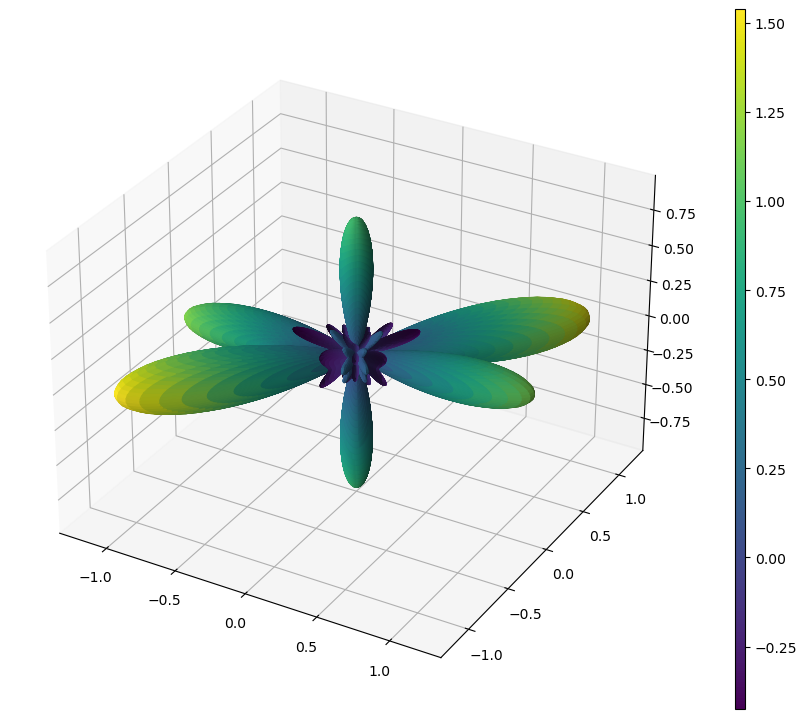

In [9]:
x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(all_fODFs[plotting_index],max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cmap(normalization(fcolors)), shade=True)
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

### fODFs expansion coefficients

In [10]:
all_fODFs[plotting_index]

array([ 2.82094792e-01,  2.94339064e-01,  0.00000000e+00, -1.04295533e-01,
        0.00000000e+00,  1.63636565e-01,  9.13697178e-02,  0.00000000e+00,
       -2.54905107e-01, -1.53075976e-17,  4.35362910e-01,  1.91693151e-18,
       -1.41713422e-01,  0.00000000e+00, -9.85625236e-02, -1.12662893e-01,
        0.00000000e+00, -7.36646215e-02, -9.29403636e-18,  2.48178192e-01,
        3.01970145e-17, -2.00116524e-02, -3.78149533e-18,  1.37973622e-01,
        4.39918294e-17,  7.94636470e-02,  0.00000000e+00,  1.90172911e-01,
        2.99831858e-01,  0.00000000e+00,  8.77862191e-02,  4.72721388e-17,
        6.98470547e-02,  1.74064351e-17, -2.45780279e-01, -4.49918553e-17,
        5.06575989e-01,  5.63421561e-18, -1.36640512e-01, -8.23905668e-17,
       -7.53455537e-02,  4.15233717e-17, -1.48181538e-01,  0.00000000e+00,
        3.98146781e-01])

## Pre-processing

In [11]:
thetas, phis = convert_coords_from_cartesian_to_spherical(all_qhat[0])

## Compute spherical Fourier transform

In [12]:
design_matrix = get_design_matrix(max_degree = max_degree ,number_of_samples=len(all_bvals[0]), thetas=thetas, phis=phis)
spherical_fourier_transform = get_spherical_fourier_transform(design_matrix)

## Compute inverse spherical Fourier transform

In [13]:
inverse_spherical_fourier_transform = get_inverse_spherical_fourier_transform(design_matrix)

## Convert numpy arrays to tensors

In [14]:
spherical_fourier_transform = torch.from_numpy(spherical_fourier_transform).float()
inverse_spherical_fourier_transform = torch.from_numpy(inverse_spherical_fourier_transform).float()

In [15]:
model = SCNNModel(number_of_shells, number_of_shells, max_degree, spherical_fourier_transform, inverse_spherical_fourier_transform)


torch.Size([16, 1, 5])
torch.Size([32, 16, 5])
torch.Size([64, 32, 5])
torch.Size([32, 64, 5])
torch.Size([16, 32, 5])
torch.Size([1, 16, 5])


## Train the S-CNN

In [16]:
all_dwis_sh_coefficients = np.expand_dims(all_dwis_sh_coefficients,1)

# Create the neural network
model = SCNNModel(number_of_shells, number_of_shells, max_degree, spherical_fourier_transform, inverse_spherical_fourier_transform)

# Loss function and optimizer
criterion = CrossCorrelationLoss(max_degree=8)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data arrays
train_data = all_dwis_sh_coefficients[:80000]
train_targets = all_fODFs[:80000]

val_data = all_dwis_sh_coefficients[80000:90000]
val_targets = all_fODFs[80000:90000]

test_data = all_dwis_sh_coefficients[90000:]
test_targets = all_fODFs[90000:]

# Lists to store errors for plotting
train_errors = []
val_errors = []
test_errors = []

device = torch.device('mps')
model.to(device)

start_time = time.time()

# Training loop
for batch in range(num_batches):
    
    # Adjust learning rate
    if batch == num_batches - num_batches_lr_reduction:
        for param_group in optimizer.param_groups:
            param_group['lr'] = final_learning_rate
    elif batch == num_batches - num_batches_lr_reduction2:
        for param_group in optimizer.param_groups:
            param_group['lr'] = final_learning_rate2

    indices = torch.randperm(len(train_data))[:batch_size]

    inputs = torch.FloatTensor(train_data[indices])
    targets = torch.FloatTensor(train_targets[indices])
    
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_errors.append(loss.item())

    # Calculate validation
    with torch.no_grad():
        val_inputs = torch.FloatTensor(val_data).to(device)
        val_target = torch.FloatTensor(val_targets).to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_target)
        val_errors.append(val_loss.item())
        
        if(batch % 100 == 0):
            pass
            #print_training_progress(batch, num_batches, loss.item(), val_loss.item(), start_time)

torch.Size([16, 1, 5])
torch.Size([32, 16, 5])
torch.Size([64, 32, 5])
torch.Size([32, 64, 5])
torch.Size([16, 32, 5])
torch.Size([1, 16, 5])

self.ls
tensor([0, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       device='mps:0')

self.ls.shape
torch.Size([45])

(self.ls / 2).long()
tensor([0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='mps:0')

weights_expanded.shape
torch.Size([16, 1, 45])

self.ls.unsqueeze(0).unsqueeze(0).unsqueeze(0)
tensor([[[[0, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6,
           6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]]]],
       device='mps:0')

self.ls.unsqueeze(0).unsqueeze(0).unsqueeze(0).shape
torch.Size([1, 1, 1, 45])
x.shape
torch.Size([1000, 1, 45])
weights_expanded.unsqueeze(0).shape
torch.Size([1, 

RuntimeError: grad can be implicitly created only for scalar outputs

## Plot training and validation errors

In [ ]:
plt.plot(train_errors, label='Train Error')
plt.plot(val_errors, label='Validation Error')
plt.xlabel('Batches')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
val_outputs

## Save model weights

In [ ]:
torch.save(model.state_dict(), './model_weights.pth')

## Load data with rotations

In [ ]:
all_dwis = np.load('./data/planar/rotation/diffusion_weighted_signals.npy') / b_0_signal
all_fODFs = np.load('./data/planar/rotation/fODF_sh_coefficients.npy')
all_qhat = np.load('./data/planar/rotation/gradient_orientations.npy')
all_bvals = np.load('./data/planar/rotation/b_values.npy')
all_dwis_sh_coefficients = np.load("./data/planar/no_rotation/diffusion_weighted_signals_sh_coefficients.npy")
all_dwis_sh_coefficients = np.expand_dims(all_dwis_sh_coefficients,1)

## Model evaluation

In [ ]:
rotated_inputs = torch.FloatTensor(all_dwis_sh_coefficients[:10000]).to(device)
rotated_target = torch.FloatTensor(all_fODFs[:10000]).to(device)
rotated_outputs = model(rotated_inputs)
rotated_loss = criterion(rotated_outputs, rotated_target)
rotated_loss.item()

In [ ]:
test_errors[-1]

In [ ]:
rotated_loss.item() / val_errors[-1]

In [ ]:
model(torch.randn(1000,1,45).to('mps')).shape

In [ ]:
plt.plot(train_errors[9000:], label='Train Error')
plt.xlabel('Batches')
plt.ylabel('Mean Squared Error')
plt.yscale("log")
plt.xscale("linear")
plt.legend()
plt.show()

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

In [ ]:
all_dwis_sh_coefficients.shape

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd

from models.sphericaldeconvolution.spherical_deconvolution import spherical_deconvolution_fit
from models.sphericaldeconvolution.fibre_response_function import simple_fibre_response_function, diffusion_tensor_response_function
from dataloader.load_dt_simulated import load_dt_simulated_multiple_populations
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion
from sphericalharmonics.spherical_fourier_transform import get_spherical_harmonics_expansion_coefficients

In [ ]:
#%matplotlib qt

x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(get_spherical_harmonics_expansion_coefficients, max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(fcolors), shade=True)
#ax.set_axis_off()
plt.gca().set_aspect('equal')

#ax.plot([-0.99834138,0],[-0.0575716,0],[0,0])
#ax.plot([-0.57181506,0],[-0.82038256,0],[0,0])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

In [ ]:
#voxel = dwis

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection="3d")

# Remove ticks
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.xaxis.set_tick_params(color=(0, 0, 0, 0))
ax.yaxis.set_tick_params(color=(0, 0, 0, 0))
ax.zaxis.set_tick_params(color=(0, 0, 0, 0))

ax.scatter(all_qhat[0][0],all_qhat[0][1],all_qhat[0][2],c=all_dwis[0],vmin=np.min(all_dwis[0]),vmax=np.max(all_dwis[0]))
#ax.plot([-2,2],[0,0],[0,0])
ax.set_aspect('equal')

# Add colorbar
cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(all_dwis[0]), vmax=np.max(all_dwis[0]))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

In [ ]:
val_inputs[0].squeeze()